In [18]:
from google.colab import auth
from googleapiclient.discovery import build
from io import FileIO
from googleapiclient.http import MediaIoBaseDownload

import pandas as pd
import nltk
from sklearn.model_selection import train_test_split

try:
  stop_words = nltk.corpus.stopwords.words("english")
except:
  nltk.download('stopwords')
  stop_words = nltk.corpus.stopwords.words("english")

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import CosineSimilarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#  Get the files from google drive
auth.authenticate_user()
drive_service = build('drive', 'v3')

# Get english train data file
file_id = '1m3Ax9Z8OHMU-7FqraKc-ddI3YQ7yY_Q6'  # file id on the Google Drive
downloaded = FileIO("en.trial.complete.json", 'w')
request = drive_service.files().get_media(fileId=file_id)
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  status, done = downloader.next_chunk()
  print("Download {}%.".format(int(status.progress() * 100)))

Download 100%.


In [247]:
# en_df = pd.read_json("trial-data_all/en.trial.complete.json")
en_df = pd.read_json("en.trial.complete.json")
en_df.head()

,id,word,pos,gloss,example,type,counts,f_rnk,concrete,polysemous,sgns,char,electra
0,en.trial.1,beautiful,adjective,Pleasant ; clear .,"It 's beautiful outside , let 's go for a walk .",synonym/antonym-based,124908,706,0,0,"[1.393769145, 0.7516670227000001, -2.581333160...","[0.295645088, 0.098426342, 0.0463486575, 0.016...","[0.0800914839, -0.1875839084, -0.0411579385000..."
1,en.trial.2,cocktail,noun,A mixture of other substances or things .,a cocktail of illegal drugs,hypernym-based,4187,13245,1,0,"[2.0872907639, 0.2617726326, 0.668431639700000...","[0.3878918886, 0.1971583217, -0.44026631120000...","[-1.4771454334, -0.4742421806, 0.0847439319, -..."
2,en.trial.3,institutionalized,adjective,Having been established as an institution .,It is very difficult to get bureaucracies to a...,paraphrastic,961,35934,0,0,"[0.7893871069, -0.43510755900000003, 0.8553860...","[-0.0519028902, 0.2257766128, -0.1839749813, 0...","[-1.1030955315, -0.9046602845, 0.1503403783, -..."
3,en.trial.4,menial,noun,"A servant , especially a domestic servant .","The world was awake to the 2nd of May , but Ma...",hypernym-based,517,53267,1,1,"[0.1222261563, 0.1572209597, 0.5396134257, -0....","[-0.3667449057, -0.1431699395, -0.0671329796, ...","[-1.6584062576, -0.24498166140000002, 0.150174..."
4,en.trial.5,seek,verb,To try to find ; to look for ; to search for .,"Not long ago , it was difficult to produce pho...",paraphrastic,25195,3212,0,0,"[1.1894155741, 1.3668279648000001, -1.61634504...","[0.6137102246, 0.5464909673, -0.0161557049, 9....","[-0.5474479198000001, -0.0880863219, 0.0784259..."


In [248]:
def clean(gloss):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  cleaned = tokenizer.tokenize(gloss)
  cleaned = list(set([word.lower() for word in cleaned]))
  # stop words should be replaced with x most frequent words
  cleaned = [word for word in cleaned if not word in stop_words]
  return cleaned

gloss_lists = en_df.gloss.apply(clean)
gloss_lists

0                                      [clear, pleasant]
1                          [substances, things, mixture]
2                             [institution, established]
3                        [especially, domestic, servant]
4                              [find, search, look, try]
                             ...                        
195                        [animal, plant, color, cells]
196                                [seeming, appearance]
197       [person, travel, permission, vehicle, proceed]
198                      [around, sitting, much, moving]
199    [achievement, word, forming, phrase, heraldic,...
Name: gloss, Length: 200, dtype: object

In [249]:
# list of all context words
context_voc = []
for i in range(len(gloss_lists)):
  for j in range(len(gloss_lists[i])):
    if not gloss_lists[i][j] in context_voc:
      context_voc.append(gloss_lists[i][j])

In [250]:
# true context words for each defined word (center word)
trues = []
for i in range(len(gloss_lists)):
  for j in range(len(gloss_lists[i])):
    index = context_voc.index(gloss_lists[i][j])
    # append index of center in gloss_lists, index in context_voc, and 1 for true
    trues.append([i, index, 1])


In [251]:
# mostly follows this: https://adoni.github.io/2017/11/08/word2vec-pytorch/
class SGNS(nn.Module):
    def __init__(self) -> 'SGNS':
        super(SGNS, self).__init__()
        self.center_embs = nn.Embedding(len(gloss_lists), 256, sparse = True)
        self.context_embs = nn.Embedding(len(context_voc), 256, sparse = True)
        nn.init.xavier_uniform_(self.center_embs.weight)
        nn.init.xavier_uniform_(self.context_embs.weight)
    def forward(self, center:'center index', pos_con:'trues index', neg_cons:'list of falses indices')->'scores':
        scores = []
        center_emb = self.center_embs(torch.LongTensor([center]))
        pos_context_emb = self.context_embs(torch.LongTensor([pos_con]))
        pos_score = torch.mul(center_emb, pos_context_emb).squeeze()
        pos_score = torch.sum(pos_score)
        pos_score = nn.functional.logsigmoid(pos_score)
        scores.append(pos_score)

        for neg_con in neg_cons:
            neg_context_emb = self.context_embs(torch.LongTensor([neg_con]))
            neg_score = torch.mul(center_emb, neg_context_emb).squeeze()
            neg_score = torch.sum(neg_score)
            neg_score = nn.functional.logsigmoid(-1 * neg_score)
            scores.append(neg_score)

        return -1 * sum(torch.stack(scores))
        
sgns = SGNS()
sgns

SGNS(
  (center_embs): Embedding(200, 256, sparse=True)
  (context_embs): Embedding(769, 256, sparse=True)
)

In [252]:
optim = torch.optim.SparseAdam(sgns.parameters(), lr = .001)

# number of negative pairs for each train. 2 - 5 usually works well for large datasets
neg_count = 3
epochs = 100

for i in range(epochs):
    for j in range(len(gloss_lists)):
        optim.zero_grad()
        # to add: choice distribution based on frequency raised to 3/4 power
        falses = np.random.choice(len(context_voc), neg_count, replace = False)
        loss = sgns.forward(trues[i][0], trues[i][1], falses)
        loss.backward()
        optim.step()
    if i % 10 == 0:
        print(loss.data)
print(loss.data)

tensor(2.0530)
tensor(0.7623)
tensor(0.0939)
tensor(0.0380)
tensor(0.0445)
tensor(0.0337)
tensor(0.0833)
tensor(0.2255)
tensor(0.0349)
tensor(0.0742)
tensor(0.0169)


In [253]:
embeddings = sgns.center_embs.weight.tolist()
print(len(embeddings), len(embeddings[0]))

200 256


In [255]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, en_df.sgns)
print(X_train[0][:5], "\n", y_train[0][:5])

[0.08073222637176514, -0.06900676339864731, 0.09153136610984802, -0.06413134187459946, -0.09939511865377426] 
 [1.393769145, 0.7516670227000001, -2.5813331604, 0.41164046530000004, -0.9959195852]


In [256]:
y_train = y_train.to_list()
y_test = y_test.to_list()

In [257]:
X_train = np.asarray(X_train, dtype = np.float32)
X_test = np.asarray(X_test, dtype = np.float32)
y_train = np.asarray(y_train, dtype = np.float32)
y_test = np.asarray(y_test, dtype = np.float32)

In [258]:
print("Average Cosine Similarity: ", np.mean(cosine_similarity(X_test, y_test)))

Average Cosine Similarity:  -0.0026748325


In [259]:
inputs = tf.keras.Input(shape=(256,), dtype="float32")

x = layers.Dense(128, activation="relu")(inputs)

predictions = layers.Dense(256, activation="linear", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

model.compile(loss="mean_squared_error", optimizer="adam", metrics=[CosineSimilarity(axis=1)])

In [260]:
model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 256)]             0         
                                                                 
 dense_72 (Dense)            (None, 128)               32896     
                                                                 
 predictions (Dense)         (None, 256)               33024     
                                                                 
Total params: 65,920
Trainable params: 65,920
Non-trainable params: 0
_________________________________________________________________


In [261]:
n_epochs = 20
history = model.fit(X_train, y_train, epochs = n_epochs)

Epoch 1/20
5/5 [==============================] - 0s 4ms/step - loss: 1.2563 - cosine_similarity: 0.0083
Epoch 2/20
5/5 [==============================] - 0s 4ms/step - loss: 1.2400 - cosine_similarity: 0.1152
Epoch 3/20
5/5 [==============================] - 0s 5ms/step - loss: 1.2267 - cosine_similarity: 0.1865
Epoch 4/20
5/5 [==============================] - 0s 4ms/step - loss: 1.2143 - cosine_similarity: 0.2318
Epoch 5/20
5/5 [==============================] - 0s 5ms/step - loss: 1.2026 - cosine_similarity: 0.2583
Epoch 6/20
5/5 [==============================] - 0s 4ms/step - loss: 1.1898 - cosine_similarity: 0.2754
Epoch 7/20
5/5 [==============================] - 0s 4ms/step - loss: 1.1780 - cosine_similarity: 0.2871
Epoch 8/20
5/5 [==============================] - 0s 4ms/step - loss: 1.1658 - cosine_similarity: 0.2959
Epoch 9/20
5/5 [==============================] - 0s 5ms/step - loss: 1.1531 - cosine_similarity: 0.3029
Epoch 10/20
5/5 [==============================] - 0s 4

In [265]:
 #Compare Model Prediction To All Embeddings And See Which Are Most Similar
def Cosine_Similarity( x_instance, y_instance ):
    dot_product_value  = np.dot( x_instance, y_instance )
    x_instance_l2_norm = np.linalg.norm( x_instance, ord = 2 )
    y_instance_l2_norm = np.linalg.norm( y_instance, ord = 2 )
    cross_product      = x_instance_l2_norm * y_instance_l2_norm
    return dot_product_value / cross_product   

Cosine Similarity

In [266]:
pw_idx = []
pred_word_emb = model.predict(X_test, verbose =0)

for i in range(len(pred_word_emb)):
  #Finds the highest value per predicted Cossim and saves the highest ID per embeddings
  cossim_value = Cosine_Similarity(pred_word_emb[i], y_test[i])
  pw_idx.append(cossim_value)

print("Average Cosine Similarity: ", np.mean(pw_idx))

Average Cosine Similarity:  0.18645829


not sure why these are different, but I'd put it down to the l2 norms

In [267]:
print("Average Cosine Similarity: ", np.mean(cosine_similarity(pred_word_emb, y_test)))

Average Cosine Similarity:  0.18811606


MSE



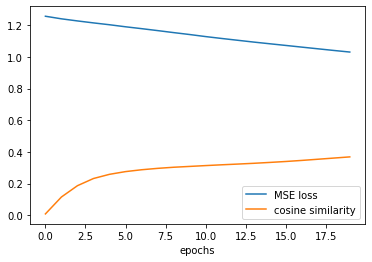

In [269]:
plt.plot(range(n_epochs), history.history["loss"])
plt.plot(range(n_epochs), history.history["cosine_similarity"])
plt.legend(["MSE loss", "cosine similarity"])
plt.xlabel("epochs")
plt.show()